In [1]:
# Install packages
!pip install pennylane pennylane-lightning pennylane-lightning[gpu] cotengra quimb --upgrade
!pip install tifffile
!pip install -U "jax[cuda12_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
# !pip install --upgrade "jax[cuda11_pip]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.8/177.8 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 48.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 73.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.7/776.7 kB 38.7 MB/s eta 0:00:00
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.5/15.5 MB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.8/100.8 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.

In [2]:
import jax
import jax.numpy as jnp

x = jnp.ones((1000, 1000))
y = jnp.dot(x, x)
print(jax.devices())


[CudaDevice(id=0)]


In [3]:
# Import packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import sys
import numpy as np
#np.set_printoptions(threshold=sys.maxsize)
import pandas as pd
from sklearn import datasets
import seaborn as sns
import jax
import time
from tifffile import tifffile
import functools

from typing import List, Union, Tuple, Dict, Optional, Any
from typing import Callable

jax.config.update("jax_enable_x64", True)
#jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp

import optax  # optimization using jax

import torch  # https://pytorch.org
import torchvision  # https://pytorch.org
#torch.set_printoptions(profile="full")
import pennylane as qml
import pennylane.numpy as pnp

import os, cv2, itertools # cv2 -- OpenCV
import shutil
import zipfile
%matplotlib inline

from jax.lib import xla_bridge

def set_jax_platform():
    # Check if TPU is available
    try:
        tpu_backend = xla_bridge.get_backend('tpu')
        if tpu_backend and tpu_backend.device_count() > 0:
            # Set platform to TPU
            jax.config.update('jax_platform_name', 'tpu')
            print("Set platform to TPU")
            return
    except RuntimeError:
        pass  # No TPU found, move on to check for GPU

    # Check if GPU is available
    try:
      gpu_backend = xla_bridge.get_backend('gpu')
      if gpu_backend and gpu_backend.device_count() > 0:
          # Set platform to CUDA (GPU)
          jax.config.update('jax_platform_name', 'gpu')
          print("Set platform to GPU")
    except RuntimeError:
          # Set platform to CPU
          jax.config.update('jax_platform_name', 'cpu')
          print("Set platform to CPU")

# Call the function to set the platform
set_jax_platform()

sns.set()

seed = 1701
rng = np.random.default_rng(seed=seed)
prng = pnp.random.default_rng(seed=seed)
jrng_key = jax.random.PRNGKey(seed)

Set platform to GPU


<ipython-input-3-18305dd46f60>:40: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  tpu_backend = xla_bridge.get_backend('tpu')
<ipython-input-3-18305dd46f60>:51: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  gpu_backend = xla_bridge.get_backend('gpu')


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
ROWS, COLS = 32, 32

# Extract data from https://www.kaggle.com/datasets/kmader/siim-medical-images
data_zip = '/content/drive/MyDrive/Datasets/CTMedicalImages/archive.zip'

# extract the file
with zipfile.ZipFile(data_zip, 'r') as zip_ref:
    zip_ref.extractall(os.getcwd())

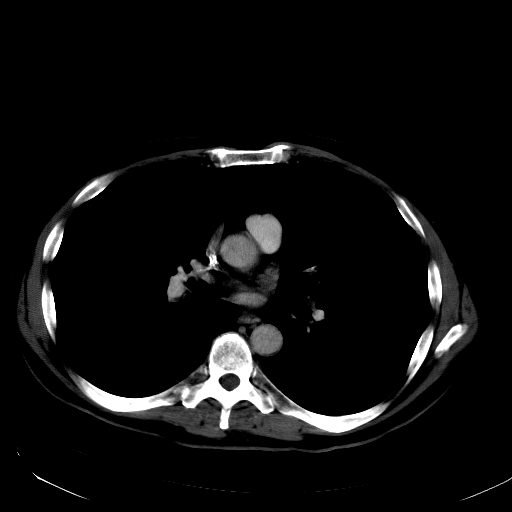

In [6]:
from google.colab.patches import cv2_imshow
overview_df = pd.read_csv('overview.csv')
overview_df.columns = ['id']+list(overview_df.columns[1:])
overview_df['Contrast'] = overview_df['Contrast'].map(lambda x: 1 if x else 0) #1 for contrast, 0 for no contrast
dummy_img = tifffile.imread(os.path.join('tiff_images', overview_df['tiff_name'][0]))
cv2_imshow(dummy_img)

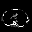

In [7]:
resized = cv2.resize(dummy_img, (ROWS, COLS),interpolation=cv2.INTER_CUBIC)
cv2_imshow(resized)

In [8]:
def read_tiff_and_resize(filepath, resize_row = 32, resize_col = 32):
  img = tifffile.imread(filepath)
  return cv2.resize(img, (resize_row, resize_col),interpolation=cv2.INTER_CUBIC)



class CTImgHerm(torch.utils.data.Dataset):
    def __init__(self, overview_csv='overview.csv', tiff_img_folder='tiff_images', resize_col = 32, resize_row = 32):
        self.overview_df = pd.read_csv('overview.csv')
        self.overview_df.columns = ['idx']+list(overview_df.columns[1:])
        self.overview_df['Contrast'] = overview_df['Contrast'].map(lambda x: 1 if x else 0) #1 for contrast, 0 for no contrast
        self.resize_col = resize_col
        self.resize_row = resize_row

        self.data = []

        for i in range(len(self.overview_df)):
          img = read_tiff_and_resize(os.path.join(tiff_img_folder, overview_df['tiff_name'][i]), resize_row = self.resize_row , resize_col =self.resize_col)
          img = cv2.normalize(img, None, 0, 1.0,cv2.NORM_MINMAX, dtype=cv2.CV_32F)
          label = self.overview_df['Contrast'][i]
          self.data.append((img, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        img = (img + np.transpose(img))/2
        return img, label

dummy_dataset = CTImgHerm()
dummy_dataset[0]

(array([[0.00067681, 0.00067681, 0.00067681, ..., 0.00067681, 0.00067681,
         0.00067681],
        [0.00067681, 0.00067681, 0.00067681, ..., 0.00858719, 0.00069783,
         0.00067681],
        [0.00067681, 0.00067681, 0.00067681, ..., 0.05319135, 0.00705113,
         0.00054893],
        ...,
        [0.00067681, 0.00858719, 0.05319135, ..., 0.07699811, 0.0740454 ,
         0.04863514],
        [0.00067681, 0.00069783, 0.00705113, ..., 0.0740454 , 0.41830966,
         0.02946547],
        [0.00067681, 0.00067681, 0.00054893, ..., 0.04863514, 0.02946547,
         0.00067681]], dtype=float32),
 1)

In [9]:
def img_hermitian_evolve(
    img:jnp.ndarray,
    t:float
)->jnp.ndarray:
  assert img.shape[-1]==32 and img.shape[-2] == 32, f"The shape of the image must be 32 by 32, got {img.shape[-2]} by {img.shape[-1]}"
  return jax.scipy.linalg.expm(img*( -0.5j*t))

print(
    img_hermitian_evolve(
        dummy_dataset[0][0],
        10
        )[16]
    )

[ 0.03316834+0.10185403j  0.03990275+0.01448904j -0.01340654-0.11395637j
 -0.09734283-0.04602238j -0.02874839-0.10615511j  0.03417724-0.0231277j
  0.31355855-0.00824658j -0.02404667+0.14984643j -0.20052674-0.04882964j
  0.14395793+0.08981129j  0.1990049 -0.210869j   -0.27399263+0.07857375j
 -0.06780967-0.25949493j  0.26647484-0.00677687j  0.05676082-0.0082445j
 -0.06779608-0.04115491j  0.11816131-0.20410226j -0.08650953-0.03623072j
 -0.04554248+0.09426466j  0.15362452+0.02755849j  0.07865272-0.17987852j
 -0.07149893+0.21788627j  0.08791468-0.09473701j  0.01336784+0.02959449j
  0.23885594-0.01219563j  0.15551719-0.15525931j  0.0274305 -0.07152441j
  0.18937154+0.15392612j -0.07521366+0.0550395j  -0.04855048-0.09508036j
 -0.04012334-0.05201115j  0.05081468-0.17594492j]


In [10]:
ket = {
    '0':jnp.array([1,0]),
    '1':jnp.array([0,1]),
    '+':(jnp.array([1,0]) + jnp.array([0,1]))/jnp.sqrt(2),
    '-':(jnp.array([1,0]) - jnp.array([0,1]))/jnp.sqrt(2)
}

pauli = {
    'I':jnp.array([[1,0],[0,1]]),
    'X':jnp.array([[0,1],[1,0]]),
    'Y':jnp.array([[0, -1j],[1j, 0]]),
    'Z':jnp.array([[1,0],[0,-1]])
}

def tensor_product(*args):
  input_list = [a for a in args]
  return functools.reduce(jnp.kron, input_list)

def multi_qubit_identity(n_qubits:int)->jnp.ndarray:
  assert n_qubits>0
  if n_qubits == 1:
    return pauli['I']
  else:
    return tensor_product(*[pauli['I'] for _ in range(n_qubits)])

pauli_words_su4 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    if not (key1==key2 and key1=='I' and key2=='I'):
      pauli_words_su4[key1+key2] = tensor_product(pauli[key1], pauli[key2])

pauli_words_su8 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    for key3 in pauli.keys():
      if not key1+key2+key3 == 'III':
        pauli_words_su8[key1+key2+key3] = tensor_product(pauli[key1], pauli[key2], pauli[key3])

pauli_words_su16 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    for key3 in pauli.keys():
      for key4 in pauli.keys():
        if not key1+key2+key3+key4 == 'IIII':
          pauli_words_su16[key1+key2+key3+key4] = tensor_product(
              pauli[key1],
              pauli[key2],
              pauli[key3],
              pauli[key4]
          )

pauli_words_su32 = {}
for key1 in pauli.keys():
  for key2 in pauli.keys():
    for key3 in pauli.keys():
      for key4 in pauli.keys():
        for key5 in pauli.keys():
          if not key1+key2+key3+key4+key5 == 'IIIII':
            pauli_words_su32[key1+key2+key3+key4+key5] = tensor_product(
                pauli[key1],
                pauli[key2],
                pauli[key3],
                pauli[key4],
                pauli[key5]
            )

observables_2_cls_5q = [0]*2
for i in ['0', '1']:
      idx = int(i, 2)
      basis_state =ket[i]
      single_qubit_obs = jnp.outer(basis_state, basis_state)
      observables_2_cls_5q[idx] = tensor_product(single_qubit_obs, multi_qubit_identity(4))

print(observables_2_cls_5q)

[Array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64), Array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)]


In [11]:
def su4_op(
    params:jnp.ndarray
):
  generator = jnp.einsum("i, ijk -> jk", params, jnp.asarray(list(pauli_words_su4.values())))
  return jax.scipy.linalg.expm(1j*generator)

def brickwall_su4_5q_single_layer(
    params:jnp.ndarray
):
  """
  A brickwall layer of su4 gates on 5 qubits.
  Second stack is three su4 on qubit pairs (1,2), (3,4)
  First stack is two su4 on qubit pairs (2,3), (4,5)
  """
  second_stack = tensor_product(
      su4_op(params[:15]),
      su4_op(params[15:30]),
      multi_qubit_identity(1)
  )
  first_stack = tensor_product(
      multi_qubit_identity(1),
      su4_op(params[30:45]),
      su4_op(params[45:60]),
  )
  return jnp.dot(second_stack, first_stack)

def su32_op(
    params:jnp.ndarray
):
  generator = jnp.einsum("i, ijk - >jk", params, jnp.asarray(list(pauli_words_su32.values())))
  return jax.scipy.linalg.expm(1j*generator)

test_params = jax.random.normal(shape=[60], key=jrng_key)
print(brickwall_su4_5q_single_layer(test_params).shape)

(32, 32)


In [12]:
def measure_sv(
    state:jnp.ndarray,
    observable:jnp.ndarray
    ):
  """
  Measure a statevector with a Hermitian observable.
  Note: No checking Hermitianicity of the observable or whether the observable
  has all real eigenvalues or not
  """
  expectation_value = jnp.dot(jnp.conj(state.T), jnp.dot(observable, state))
  return jnp.real(expectation_value)

def measure_dm(
    rho:jnp.ndarray,
    observable:jnp.ndarray
):
  """
  Measure a density matrix with a Hermitian observable.
  Note: No checking Hermitianicity of the observable or whether the observable
  has all real eigenvalues or not.
  """
  product = jnp.dot(rho, observable)

  # Calculate the trace, which is the sum of diagonal elements
  trace = jnp.trace(product)

  # The expectation value should be real for physical observables
  return jnp.real(trace)

vmap_measure_sv = jax.vmap(measure_sv, in_axes=(None, 0), out_axes=0)
vmap_measure_dm = jax.vmap(measure_dm, in_axes=(None, 0), out_axes=0)

def bitstring_to_state(bitstring:str):
  """
  Convert a bit string, like '0101001' or '+-+-101'
  to a statevector. Each character in the bitstring must be among
  0, 1, + and -
  """
  assert len(bitstring)>0
  for c in bitstring:
    assert c in ['0', '1', '+', '-']
  single_qubit_states = [ket[c] for c in bitstring]
  return tensor_product(*single_qubit_states)

In [13]:
def qnn_hamevo(
    params:jnp.ndarray,
    t:jnp.ndarray,
    img:jnp.ndarray
)->jnp.ndarray:
  """
  A QNN that takes (M+M^T)/2
  as input, where M is the (rescaled) original image,
  as well as a trainable parameter t,
  and parameters for the trainable layers
  and output an array of 2 elements representing classification logits
  """
  single_op_params = 60 #4**5-1

  n_outer_layers = len(t)
  n_inner_layers = (len(params)//single_op_params)//n_outer_layers
  state = tensor_product(ket['+'], ket['+'], ket['+'], ket['+'], ket['+'])
  for i in range(n_outer_layers):
    state = jnp.dot(
      img_hermitian_evolve(img, t[i]),
      state
      )
    inner_layer_params = params[i*(single_op_params*n_inner_layers):(i+1)*(single_op_params*n_inner_layers)]
    for j in range(n_inner_layers):
      state = jnp.dot(
          brickwall_su4_5q_single_layer(inner_layer_params[j*single_op_params:(j+1)*single_op_params]),#su32_op(inner_layer_params[j*single_op_params:(j+1)*single_op_params]),
          state
      )
  return vmap_measure_sv(state, jnp.asarray(observables_2_cls_5q))



print(
    qnn_hamevo(
        jax.random.normal(shape=[60*15], key=jrng_key),
        jax.random.normal(shape=[15], key=jrng_key),
        dummy_dataset[0][0]
    )
)

[0.44247169 0.55752831]


In [14]:
@jax.jit
def compute_out(weight,t, features, labels):
    """Computes the output of the corresponding label in the qcnn"""
    out = lambda weight,t, feature, label: qnn_hamevo(weight,t, feature)
    return jax.vmap(out, in_axes=(None,None,  0, 0), out_axes=0)(
        weight,t, features, labels
    )


def compute_accuracy(weight,t, features, labels):
    """Computes the accuracy over the provided features and labels"""
    out = compute_out(weight,t, features, labels)
    pred = jnp.argmax(out, axis = 1)
    return jnp.sum(jnp.array(pred == labels).astype(int)) / len(out)


def compute_cost(weight,t, features, labels):
    """Computes the cost over the provided features and labels"""
    logits = compute_out(weight,t, features, labels)
    return jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(logits, labels))


value_and_grad = jax.jit(jax.value_and_grad(compute_cost, argnums=[0,1]))

In [15]:
N_OUTER_LAYERS = 2
N_INNER_LAYERS = 1
N_LAYERS = N_OUTER_LAYERS*N_INNER_LAYERS
SINGLE_OP_PARAMS  = 60 #4**5-1

def init_weights_random():
    print("Random Init")
    return jax.random.normal(shape=[SINGLE_OP_PARAMS*N_LAYERS], key=jrng_key),jax.random.normal(shape=[N_OUTER_LAYERS], key=jrng_key)

def init_weights_beta(alpha=0.5, beta=2.0):
    # Initialize weights with a Beta distribution skewed towards 0
    weights = jax.random.beta(jrng_key, alpha, beta, shape=[SINGLE_OP_PARAMS*N_LAYERS])
    biases = jax.random.beta(jrng_key, alpha, beta, shape=[N_OUTER_LAYERS])
    return weights, biases

In [16]:
import pandas as pd
import os

def save_weights_to_csv(weights, biases, epoch, file_name='weights.csv'):
    """Saves the weights and biases to a CSV file."""
    # Convert weights and biases to a flat list
    weight_list = weights.flatten().tolist()
    bias_list = biases.flatten().tolist()

    # Create a dictionary to store the weights and biases with epoch
    data = {'epoch': [epoch], 'weights': [weight_list], 'biases': [bias_list]}

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Check if the file exists before appending
    if not os.path.isfile(file_name):
        # If the file does not exist, create it with a header
        df.to_csv(file_name, mode='w', header=True, index=False)
    else:
        # If the file exists, append the new data without a header
        df.to_csv(file_name, mode='a', header=False, index=False)


In [17]:
# def train_vqc(batchsize:int, n_epochs:int, seed:int=1701):
#   start = time.time()
#   pnp.random.seed(seed)
#   np.random.seed(seed)
#   # load data
#   full_dataset = CTImgHerm()
#   train_size = int(0.8 * len(full_dataset))
#   test_size = len(full_dataset) - train_size
#   train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
#   trainloader = torch.utils.data.DataLoader(
#     train_dataset, batch_size=batchsize, shuffle=True
#   )
#   testloader = torch.utils.data.DataLoader(
#     test_dataset, batch_size=batchsize, shuffle=True
#   )
#   # Exponential decay of the learning rate.
#   scheduler = optax.exponential_decay(
#     init_value=0.01,
#     transition_steps=n_epochs,
#     decay_rate=0.99)

#   # Combining gradient transforms using `optax.chain`.
#   gradient_transform = optax.chain(
#     optax.clip(1.0),
#     optax.scale_by_adam(),  # Use the updates from adam.
#     optax.scale_by_schedule(scheduler),  # Use the learning rate from the scheduler.
#     # Scale updates by -1 since optax.apply_updates is additive and we want to descend on the loss.
#     optax.scale(-1.0)
#   )
#   # init weights and optimizer
#   weights, weights_last = init_weights()
#   opt_state = gradient_transform.init((weights, weights_last))
#   #data containers
#   train_cost_epochs, test_cost_epochs, train_acc_epochs, test_acc_epochs = [], [], [], []
#   for step in range(n_epochs):
#         train_cost_batches = []
#         train_acc_batches = []
#         test_cost_batches = []
#         test_acc_batches = []
#         epoch_start = time.time()
#         print(f"Training at Epoch {step+1}/{n_epochs}, Train batches {len(trainloader)}, Test batches {len(testloader)}......")
#         for batch, (x_train, y_train) in enumerate(trainloader):
#           batch_start = time.time()
#           # Training step with (adam) optimizer
#           x_train, y_train = jnp.asarray(x_train.numpy()), jnp.asarray(y_train.numpy())
#           train_cost, grad_circuit = value_and_grad(weights, weights_last, x_train, y_train)
#           updates, opt_state = gradient_transform.update(grad_circuit, opt_state)
#           weights, weights_last = optax.apply_updates((weights, weights_last), updates)
#           train_acc = compute_accuracy(weights, weights_last, x_train, y_train)
#           train_cost_batches.append(train_cost)
#           train_acc_batches.append(train_acc)
#           if len(trainloader)<= 5 or (batch+1)%5==0:
#             print(f"Training at Epoch {step+1}/{n_epochs}, Batch {batch+1}, Cost {train_cost}, Acc {train_acc}. Time {time.time()-batch_start}")


#         train_cost_epochs.append(np.mean(train_cost_batches))
#         train_acc_epochs.append(np.mean(train_acc_batches))


#         # load test data
#         for batch, (x_test, y_test) in enumerate(testloader):
#           batch_start = time.time()
#           x_test, y_test = jnp.asarray(x_test.numpy()), jnp.asarray(y_test.numpy())
#           # compute accuracy and cost on testing data
#           test_out = compute_out(weights, weights_last, x_test, y_test)
#           test_pred = jnp.argmax(test_out, axis=1)
#           test_acc = jnp.sum(jnp.array(test_pred == y_test).astype(int)) / len(test_out)
#           test_cost = jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(test_out, y_test))
#           test_cost_batches.append(test_cost)
#           test_acc_batches.append(test_acc)
#           if len(testloader)<= 5 or (batch+1)%5==0:
#             print(f"Testing at Epoch {step+1}/{n_epochs}, Batch {batch+1}, Cost {test_cost}, Acc {test_acc}. Time {time.time()-batch_start}")
#         test_acc_epochs.append(np.mean(test_acc_batches))
#         test_cost = np.mean(test_cost_batches)
#         test_cost_epochs.append(test_cost)
#         print("......")
#         print(f"Epoch {step+1}/{n_epochs}, Train: Cost {np.mean(train_cost_batches)}, Acc {np.mean(train_acc_batches)}")
#         print(f"Epoch {step+1}/{n_epochs}, Test: Cost {test_cost}, Acc {test_acc}. Time {time.time()-epoch_start}")
#         print("=-="*10)

#   return dict(
#         n_train=[train_size] * n_epochs,
#         step=np.arange(1, n_epochs + 1, dtype=int).tolist(),
#         train_cost=[c.astype(float) for c in train_cost_epochs],
#         train_acc=[c.astype(float) for c in train_acc_epochs],
#         test_cost=[c.astype(float) for c in test_cost_epochs],
#         test_acc=[c.astype(float) for c in test_acc_epochs],
#     )



import numpy as np
import pandas as pd
import time
import torch
import optax
import jax.numpy as jnp

def train_vqc(batchsize: int, n_epochs: int, seed: int = 1701):
    start = time.time()
    np.random.seed(seed)

    # Load data once
    full_dataset = CTImgHerm()
    train_size = int(0.75 * len(full_dataset))
    val_size = int(0.05 * len(full_dataset))
    test_size = len(full_dataset) - train_size - val_size
    # Split dataset into train, validation, and test sets (fixed split for both initializations)
    train_dataset, val_test_dataset = torch.utils.data.random_split(
        full_dataset, [train_size, val_size + test_size]
    )
    val_dataset, test_dataset = torch.utils.data.random_split(
        val_test_dataset, [val_size, test_size]
    )

    # Create data loaders
    trainloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batchsize, shuffle=True
    )
    valloader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batchsize, shuffle=True
    )
    testloader = torch.utils.data.DataLoader(
        test_dataset, batch_size=batchsize, shuffle=False
    )

    # Exponential decay of the learning rate
    scheduler = optax.exponential_decay(
        init_value=0.01,
        transition_steps=n_epochs,
        decay_rate=0.99
    )
    gradient_transform = optax.chain(
        optax.clip(1.0),
        optax.scale_by_adam(),
        optax.scale_by_schedule(scheduler),
        optax.scale(-1.0)
    )

    def run_training(init_weights_func, file_name):
        """Run the training loop for a given initialization function."""
        weights, weights_last = init_weights_func()
        opt_state = gradient_transform.init((weights, weights_last))

        train_cost_epochs, val_cost_epochs = [], []
        train_acc_epochs, val_acc_epochs = [], []

        # Training and validation loop
        for step in range(n_epochs):
            train_cost_batches, train_acc_batches = [], []
            val_cost_batches, val_acc_batches = [], []

            print(f"Epoch {step+1}/{n_epochs} - Training...")


            # Training loop
            for x_train, y_train in trainloader:
                x_train, y_train = jnp.asarray(x_train.numpy()), jnp.asarray(y_train.numpy())
                train_cost, grad_circuit = value_and_grad(weights, weights_last, x_train, y_train)
                updates, opt_state = gradient_transform.update(grad_circuit, opt_state)
                weights, weights_last = optax.apply_updates((weights, weights_last), updates)
                train_acc = compute_accuracy(weights, weights_last, x_train, y_train)
                print(f"Training at Epoch {step+1}/{n_epochs}, Cost {train_cost}, Acc {train_acc}")

                train_cost_batches.append(train_cost)
                train_acc_batches.append(train_acc)

            train_cost_epochs.append(np.mean(train_cost_batches))
            train_acc_epochs.append(np.mean(train_acc_batches))

            # Validation loop
            for x_val, y_val in valloader:
                x_val, y_val = jnp.asarray(x_val.numpy()), jnp.asarray(y_val.numpy())
                val_out = compute_out(weights, weights_last, x_val, y_val)
                val_pred = jnp.argmax(val_out, axis=1)
                val_acc = jnp.sum(val_pred == y_val) / len(val_out)
                val_cost = jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(val_out, y_val))

                val_cost_batches.append(val_cost)
                val_acc_batches.append(val_acc)

            val_cost_epochs.append(np.mean(val_cost_batches))
            val_acc_epochs.append(np.mean(val_acc_batches))

        # Testing loop
        test_cost_batches, test_acc_batches = [], []
        for x_test, y_test in testloader:
            x_test, y_test = jnp.asarray(x_test.numpy()), jnp.asarray(y_test.numpy())
            test_out = compute_out(weights, weights_last, x_test, y_test)
            test_pred = jnp.argmax(test_out, axis=1)
            test_acc = jnp.sum(test_pred == y_test) / len(test_out)
            test_cost = jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(test_out, y_test))
            print('TEST ACC:', test_acc,'TEST COST:', test_cost)
            test_cost_batches.append(test_cost)
            test_acc_batches.append(test_acc)

        final_test_cost = np.mean(test_cost_batches)
        final_test_acc = np.mean(test_acc_batches)

        # Save weights to CSV
        save_weights_to_csv(weights, weights_last,n_epochs, file_name=file_name)

        return dict(
            n_train=[train_size] * n_epochs,
            n_val=[val_size] * n_epochs,
            n_test=[test_size] * n_epochs,
            step=np.arange(1, n_epochs + 1, dtype=int).tolist(),
            train_cost=[c.astype(float) for c in train_cost_epochs],
            train_acc=[c.astype(float) for c in train_acc_epochs],
            val_cost=[c.astype(float) for c in val_cost_epochs],
            val_acc=[c.astype(float) for c in val_acc_epochs],
            test_cost=final_test_cost.astype(float),
            test_acc=final_test_acc.astype(float)
        )

    # Run Loop 1: Random Initialization
    results_random = run_training(init_weights_random, file_name='random_weights.csv')

    # Run Loop 2: Beta Initialization
    results_beta = run_training(init_weights_beta, file_name='beta_weights.csv')

    # Return results for both initializations along with the testloader
    return results_random, results_beta, testloader



In [18]:
# n_epochs = 500
# n_reps = 20
# batch_size = 5000

# train_sizes = [int(0.8 * len(CTImgHerm()))]

# def run_iterations():
#     results_df = pd.DataFrame(
#         columns=["train_acc", "train_cost", "test_acc", "test_cost", "step", "n_train"]
#     )

#     for _ in range(n_reps):
#         results = train_vqc(n_epochs=n_epochs, batchsize=batch_size)
#         results_df = pd.concat(
#             [results_df, pd.DataFrame.from_dict(results)], axis=0, ignore_index=True
#         )

#     return results_df

# results_df = run_iterations()

n_epochs = 500
n_reps = 20
batch_size = 5000

# train_sizes = [int(0.8 * len(CTImgHerm()))]  # 80% train size

def run_iterations():
    results_random_df = pd.DataFrame(
        columns=["train_acc", "train_cost", "val_acc", "val_cost",
                 "test_acc", "test_cost", "step", "n_train"]
    )

    results_beta_df = pd.DataFrame(
        columns=["train_acc", "train_cost", "val_acc", "val_cost",
                 "test_acc", "test_cost", "step", "n_train"]
    )

    for _ in range(n_reps):
        # Train the model and get results
        # results = train_vqc_r(n_epochs=n_epochs, batchsize=batch_size)
        results_random, results_beta, testloader = train_vqc(batchsize=batch_size, n_epochs=n_epochs, seed=1701)

        # Convert results to DataFrame and append to the results DataFrame
        results_random_df = pd.concat(
            [results_random_df, pd.DataFrame.from_dict(results_random)],
            axis=0, ignore_index=True
        )

        results_beta_df = pd.concat(
            [results_beta_df, pd.DataFrame.from_dict(results_beta)],
            axis=0, ignore_index=True
        )

    return results_random_df,results_beta_df,testloader

# Run the iterations and store the results
results_random_df,results_beta_df,testloader = run_iterations()

Random Init
Epoch 1/500 - Training...


/usr/local/lib/python3.10/dist-packages/jax/_src/lax/lax.py:3373: ComplexWarning: Casting complex values to real discards the imaginary part
  x_bar = _convert_element_type(x_bar, x.aval.dtype, x.aval.weak_type)


Training at Epoch 1/500, Cost 0.683920462217599, Acc 0.6
Epoch 2/500 - Training...
Training at Epoch 2/500, Cost 0.6786253168212966, Acc 0.5866666666666667
Epoch 3/500 - Training...
Training at Epoch 3/500, Cost 0.6744901445674198, Acc 0.6533333333333333
Epoch 4/500 - Training...
Training at Epoch 4/500, Cost 0.6715121241331398, Acc 0.6533333333333333
Epoch 5/500 - Training...
Training at Epoch 5/500, Cost 0.6693050508313451, Acc 0.6533333333333333
Epoch 6/500 - Training...
Training at Epoch 6/500, Cost 0.6673731910754609, Acc 0.6533333333333333
Epoch 7/500 - Training...
Training at Epoch 7/500, Cost 0.6654160283852819, Acc 0.6666666666666666
Epoch 8/500 - Training...
Training at Epoch 8/500, Cost 0.6634034329329047, Acc 0.64
Epoch 9/500 - Training...
Training at Epoch 9/500, Cost 0.6614985112357895, Acc 0.6933333333333334
Epoch 10/500 - Training...
Training at Epoch 10/500, Cost 0.6599028823394565, Acc 0.7066666666666667
Epoch 11/500 - Training...
Training at Epoch 11/500, Cost 0.6587

<ipython-input-18-64a58914ae23>:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_random_df = pd.concat(
<ipython-input-18-64a58914ae23>:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_beta_df = pd.concat(


Streaming output truncated to the last 5000 lines.
Training at Epoch 4/500, Cost 0.6930977920334815, Acc 0.52
Epoch 5/500 - Training...
Training at Epoch 5/500, Cost 0.6916995720938826, Acc 0.52
Epoch 6/500 - Training...
Training at Epoch 6/500, Cost 0.6910611292634755, Acc 0.6
Epoch 7/500 - Training...
Training at Epoch 7/500, Cost 0.691471828094175, Acc 0.6
Epoch 8/500 - Training...
Training at Epoch 8/500, Cost 0.6911692768243944, Acc 0.5866666666666667
Epoch 9/500 - Training...
Training at Epoch 9/500, Cost 0.6902382408203037, Acc 0.52
Epoch 10/500 - Training...
Training at Epoch 10/500, Cost 0.6895776931232144, Acc 0.52
Epoch 11/500 - Training...
Training at Epoch 11/500, Cost 0.689440810083866, Acc 0.52
Epoch 12/500 - Training...
Training at Epoch 12/500, Cost 0.6893658248826211, Acc 0.52
Epoch 13/500 - Training...
Training at Epoch 13/500, Cost 0.6889675510575627, Acc 0.52
Epoch 14/500 - Training...
Training at Epoch 14/500, Cost 0.6883476677645584, Acc 0.52
Epoch 15/500 - Train

In [28]:
print('last epoch results')
print("RANDOM")
print(results_random_df.iloc[-1])
print("BETA")
print(results_beta_df.iloc[-1])

last epoch results
RANDOM
train_acc     0.826667
train_cost     0.55343
val_acc            0.8
val_cost       0.65327
test_acc          0.65
test_cost     0.613101
step               500
n_train             75
n_val              5.0
n_test            20.0
Name: 9999, dtype: object
BETA
train_acc     0.853333
train_cost    0.545025
val_acc            0.4
val_cost      0.678823
test_acc          0.75
test_cost     0.604731
step               500
n_train             75
n_val              5.0
n_test            20.0
Name: 9999, dtype: object


In [27]:
from google.colab import files

results_beta_df.to_csv('CT-beta-df.csv',index=False)
results_random_df.to_csv('CT-random-df.csv',index=False)

files.download('CT-beta-df.csv')
files.download('CT-random-df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [20]:
import pandas as pd

def load_weights_and_biases_from_csv(file_name):
    # Load the weights DataFrame
    weights_data = pd.read_csv(file_name)

    # Get the last epoch's weights and biases
    last_epoch = weights_data.iloc[-1]  # Get the last row
    weights = np.array(eval(last_epoch['weights']))  # Convert string representation back to array
    biases = np.array(eval(last_epoch['biases']))  # Convert string representation back to array

    return weights, biases

In [21]:
import pandas as pd
import ast
import jax.numpy as jnp
import torch
import optax



def ensemble_test_model(testloader, weights1, weights_last1, weights2, weights_last2, alpha):
    """Test the ensemble model using weights from two models and a given alpha."""
    total_cost = 0
    correct_predictions = 0
    total_samples = 0

    for x_test, y_test in testloader:
        x_test, y_test = jnp.asarray(x_test.numpy()), jnp.asarray(y_test.numpy())

        test_out1 = compute_out(weights1, weights_last1, x_test, y_test)
        test_out2 = compute_out(weights2, weights_last2, x_test, y_test)

        # Weighted ensemble output
        ensemble_out = alpha * test_out1 + (1 - alpha) * test_out2
        ensemble_pred = jnp.argmax(ensemble_out, axis=1)

        correct_predictions += jnp.sum(jnp.array(ensemble_pred == y_test).astype(int))
        total_samples += len(y_test)

        test_cost = jnp.nanmean(optax.softmax_cross_entropy_with_integer_labels(ensemble_out, y_test))
        total_cost += test_cost * len(y_test)

    avg_test_cost = total_cost / total_samples
    avg_test_acc = correct_predictions / total_samples

    return avg_test_cost, avg_test_acc

# Load weights for both models
weights1, weights_last1 = load_weights_and_biases_from_csv('beta_weights.csv')
weights2, weights_last2 = load_weights_and_biases_from_csv('random_weights.csv')
for x_test, y_test in testloader:
  x_test, y_test = jnp.asarray(x_test.numpy()), jnp.asarray(y_test.numpy())
  myout2 = compute_out(weights2,weights_last2,x_test,y_test)
  my2pred = jnp.argmax(myout2, axis=1)
  myacc = jnp.sum(my2pred == y_test) / len(myout2)


# Alpha values from 0.0 to 1.0 in steps of 0.1
alpha_values = [i / 10 for i in range(11)]

# Store results for each alpha
results = []

# Perform ensemble testing for each alpha (one run per alpha)
for alpha in alpha_values:
    print(f"Testing with alpha={alpha}")


    # Run the ensemble test model with the current alpha
    avg_cost, avg_acc = ensemble_test_model(testloader, weights1, weights_last1, weights2, weights_last2, alpha)

    # Store the result for each alpha
    results.append([alpha, avg_cost, avg_acc])

# Create a DataFrame to display results in table format
results_df = pd.DataFrame(results, columns=['Alpha', 'Average Cost', 'Average Accuracy'])

# Display the final table of results
print("\nEnsemble Test Results by Alpha:")
print(results_df)

# Save the results to a CSV file
results_df.to_csv('ensemble_test_results_by_alpha.csv', index=False)

Testing with alpha=0.0
Testing with alpha=0.1
Testing with alpha=0.2
Testing with alpha=0.3
Testing with alpha=0.4
Testing with alpha=0.5
Testing with alpha=0.6
Testing with alpha=0.7
Testing with alpha=0.8
Testing with alpha=0.9
Testing with alpha=1.0

Ensemble Test Results by Alpha:
    Alpha        Average Cost Average Accuracy
0     0.0  0.6131014909065542             0.65
1     0.1  0.6117167292880316             0.65
2     0.2  0.6104518410481592             0.65
3     0.3  0.6093076126287471             0.65
4     0.4  0.6082847787208743              0.7
5     0.5  0.6073840203418356              0.7
6     0.6   0.606605963017278              0.7
7     0.7  0.6059511750792497              0.7
8     0.8  0.6054201660904043             0.75
9     0.9  0.6050133854040143             0.75
10    1.0  0.6047312208687539             0.75


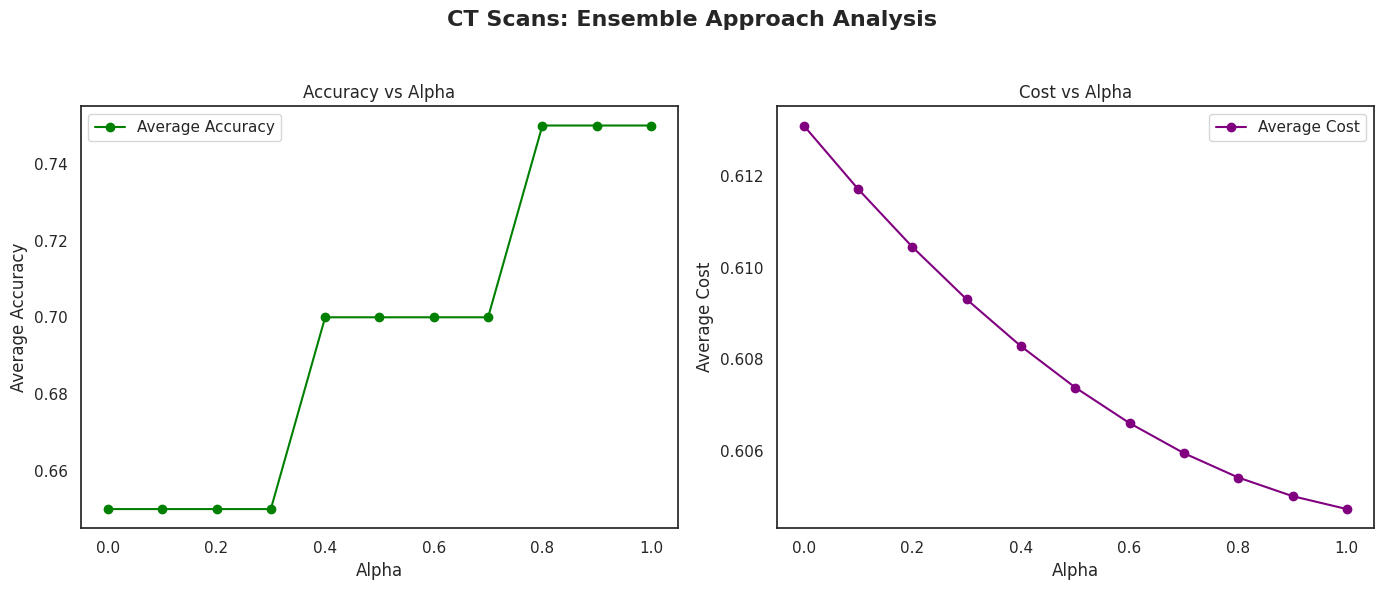

In [34]:
import matplotlib.pyplot as plt

# Data from the new table
alpha_ct = results_df['Alpha']
accuracy_ct = results_df['Average Accuracy']
cost_ct = results_df['Average Cost']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Add main title
fig.suptitle("CT Scans: Ensemble Approach Analysis", fontsize=16, fontweight="bold")

# Plot Accuracy vs Alpha on the first subplot
ax1.plot(alpha_ct, accuracy_ct, marker='o', linestyle='-', color='green', label="Average Accuracy")
ax1.set_title("Accuracy vs Alpha")
ax1.set_xlabel("Alpha")
ax1.set_ylabel("Average Accuracy")
ax1.legend()
ax1.grid(False)

# Plot Cost vs Alpha on the second subplot
ax2.plot(alpha_ct, cost_ct, marker='o', linestyle='-', color='purple', label="Average Cost")
ax2.set_title("Cost vs Alpha")
ax2.set_xlabel("Alpha")
ax2.set_ylabel("Average Cost")
ax2.legend()
ax2.grid(False)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title

# Save the figure
plt.savefig("ensemble_approach_ct_scans.pdf", dpi=300, bbox_inches="tight")
plt.show()


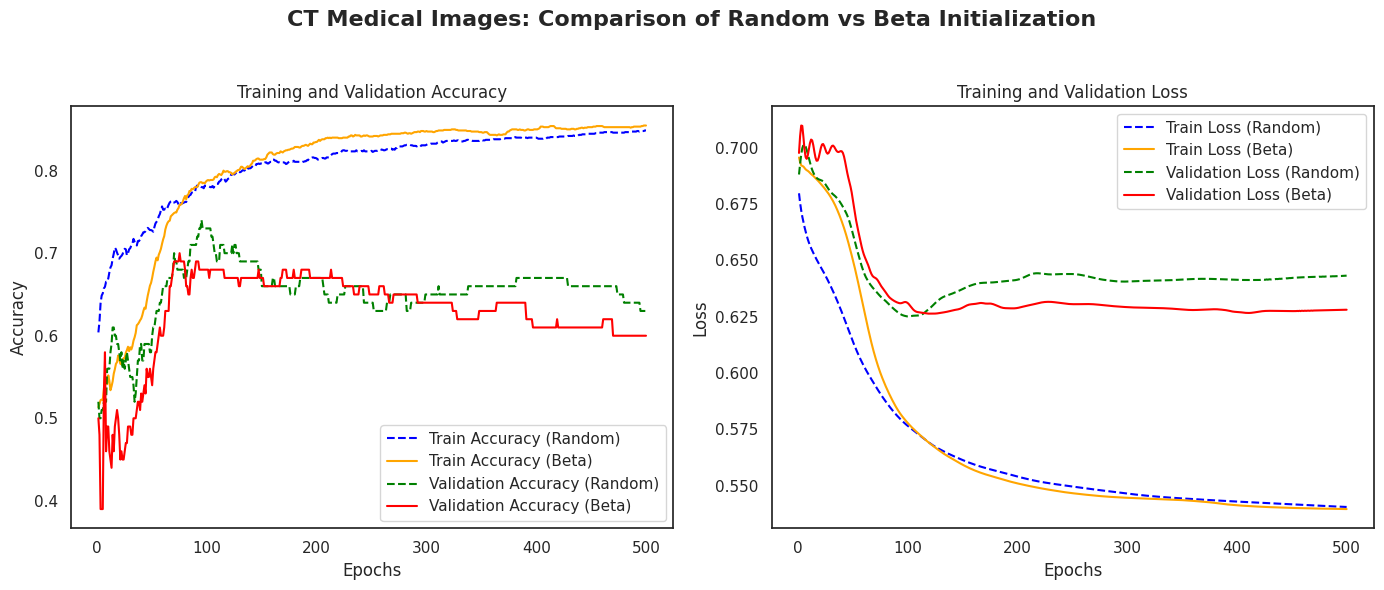

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate data for plotting (mean and std per epoch)
df_random_agg = results_random_df.groupby(["step"]).agg(["mean", "std"]).reset_index()
df_beta_agg = results_beta_df.groupby(["step"]).agg(["mean", "std"]).reset_index()

# Extract steps
steps_random = df_random_agg["step"]
steps_beta = df_beta_agg["step"]

# Extract accuracy and loss
train_acc_random = df_random_agg["train_acc"]["mean"]
val_acc_random = df_random_agg["val_acc"]["mean"]
train_acc_beta = df_beta_agg["train_acc"]["mean"]
val_acc_beta = df_beta_agg["val_acc"]["mean"]

train_loss_random = df_random_agg["train_cost"]["mean"]
val_loss_random = df_random_agg["val_cost"]["mean"]
train_loss_beta = df_beta_agg["train_cost"]["mean"]
val_loss_beta = df_beta_agg["val_cost"]["mean"]

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Add main title
fig.suptitle("CT Medical Images: Comparison of Random vs Beta Initialization", fontsize=16, fontweight="bold")

# Plot training and validation accuracy on the first subplot (ax1)
ax1.plot(steps_random, train_acc_random, label="Train Accuracy (Random)", linestyle="--", color="blue")
ax1.plot(steps_beta, train_acc_beta, label="Train Accuracy (Beta)", linestyle="-", color="orange")
ax1.plot(steps_random, val_acc_random, label="Validation Accuracy (Random)", linestyle="--", color="green")
ax1.plot(steps_beta, val_acc_beta, label="Validation Accuracy (Beta)", linestyle="-", color="red")
ax1.set_title("Training and Validation Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend()
ax1.grid(False)

# Plot training and validation loss on the second subplot (ax2)
ax2.plot(steps_random, train_loss_random, label="Train Loss (Random)", linestyle="--", color="blue")
ax2.plot(steps_beta, train_loss_beta, label="Train Loss (Beta)", linestyle="-", color="orange")
ax2.plot(steps_random, val_loss_random, label="Validation Loss (Random)", linestyle="--", color="green")
ax2.plot(steps_beta, val_loss_beta, label="Validation Loss (Beta)", linestyle="-", color="red")
ax2.set_title("Training and Validation Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()
ax2.grid(False)

# Adjust layout and save the figure
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for the title
plt.savefig("train_val_accuracy_loss_side_by_side.pdf", dpi=300, bbox_inches="tight")
plt.show()
